## Assignment 1 
### possakorn a1873765

In [1]:
## import library
import pandas as pd
import json
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# text manipulation
import re
import nltk
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# text processing
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

# model
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score # evaluation
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### 1. Reading datasets

Download JSON dataset from the assignment, and perform basic data manipulation including
- “title” field concatenated with “text” field
-  Split data into training / development / test
   -  Development dataset: we will use for all of experiments
   -  Training / testing dataset: we will use only for final model evaluation.

In [2]:
## 01 Download dataset from JSON file
df = pd.read_json('random_30000_hotel_reviews.JSON', lines=True)

def clean_data(df):
    
    ## 01 Data preparation folllowing: Your main task will be to predict "overall" score using “title” field concatenated with “text” field.
    # explode the focused column
    df = pd.concat([df, df['ratings'].apply(pd.Series)], axis=1)
    
    # concatenated content ot predict "overall" score
    df["context"] = df["title"] + " " + df["text"]
    
    # select columns
    df = df[['overall','context']]
    
    # # Keep only alphanumeric characters and spaces
    # df['context_clean'] = df['context'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))
    
    # ## 03 Tokenize the text
    # # Apply the word_tokenize method to the 'context_clean' column
    # df['tokens'] = df['context_clean'].apply(word_tokenize)
    
    ## 04 Split data
    df_train = df[:10000]
    df_dev = df[10000:20000]
    df_test = df[20000:]
    
    return df_train, df_dev, df_test
    
df_train, df_dev, df_test = clean_data(df)
df_dev.head()

,overall,context
10000,4.0,“Nice hotel - great location” This was a nice ...
10001,4.0,“Perfect location and the room was generous in...
10002,2.0,"“Rude staff, extra charges, overall unimpressi..."
10003,4.0,"“Great location, would stay here again” Stayed..."
10004,3.0,“Disappointed in Chicago” I stayed at the Alle...


### 2. Exploratory Data Analysis (EDA)

#### Check the data overview

In [3]:
## Checking the data types
df_dev.info()
df_dev.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 10000 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   overall  10000 non-null  float64
 1   context  10000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,overall
count,10000.00000
mean,3.93170
std,1.18936
min,1.00000
25%,3.00000
50%,4.00000
75%,5.00000
max,5.00000


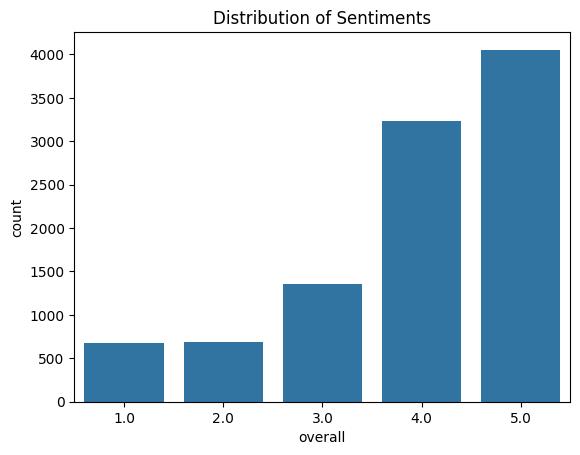

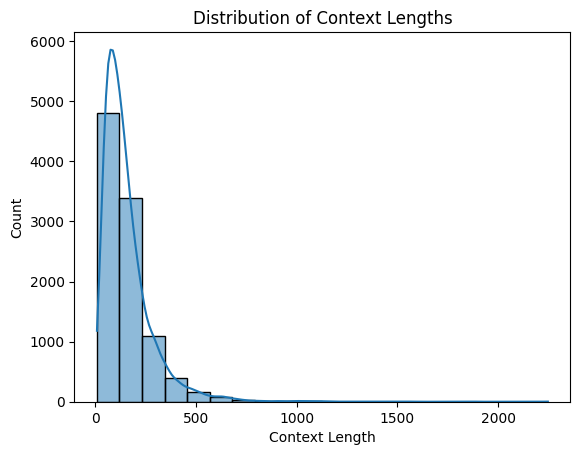

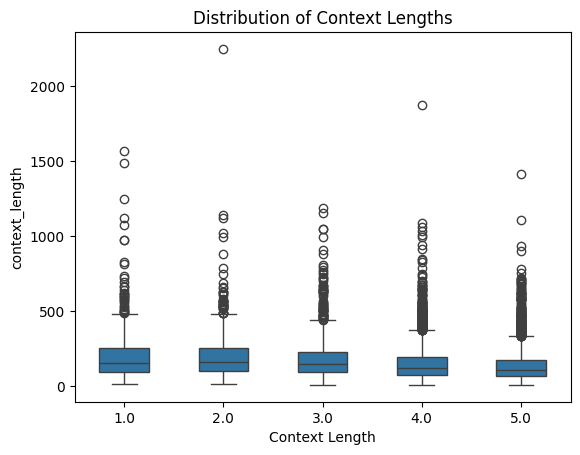

In [4]:
# Display distribution of sentiments
sns.countplot(x='overall', data=df_dev)
plt.title('Distribution of Sentiments')
plt.show()

# Analyze the distribution of tweet lengths
df_dev['context_length'] = df_dev['context'].apply(lambda x: len(x.split()))

sns.histplot(df_dev['context_length'], bins=20, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Context Length')
plt.show()

sns.boxplot(data=df_dev, 
            x="overall", 
            y="context_length", 
            width=.5)
plt.title('Distribution of Context Lengths')
plt.xlabel('Context Length')
plt.show()

#### Analysis: 
- The dataset under examination does not contain any null values and possesses a median overall score of 3.93.
- An imbalance is observed within the dataset, with a predominance of sentiments leaning towards the positive spectrum, approximately ranging from 4 to 5.
- The distribution of context lengths is notably concentrated within the 0-100 word range.
- The correlation between the length of the context and the overall scores appears to be minimal, suggesting that context length may not be a crucial factor for inclusion in predicting features.

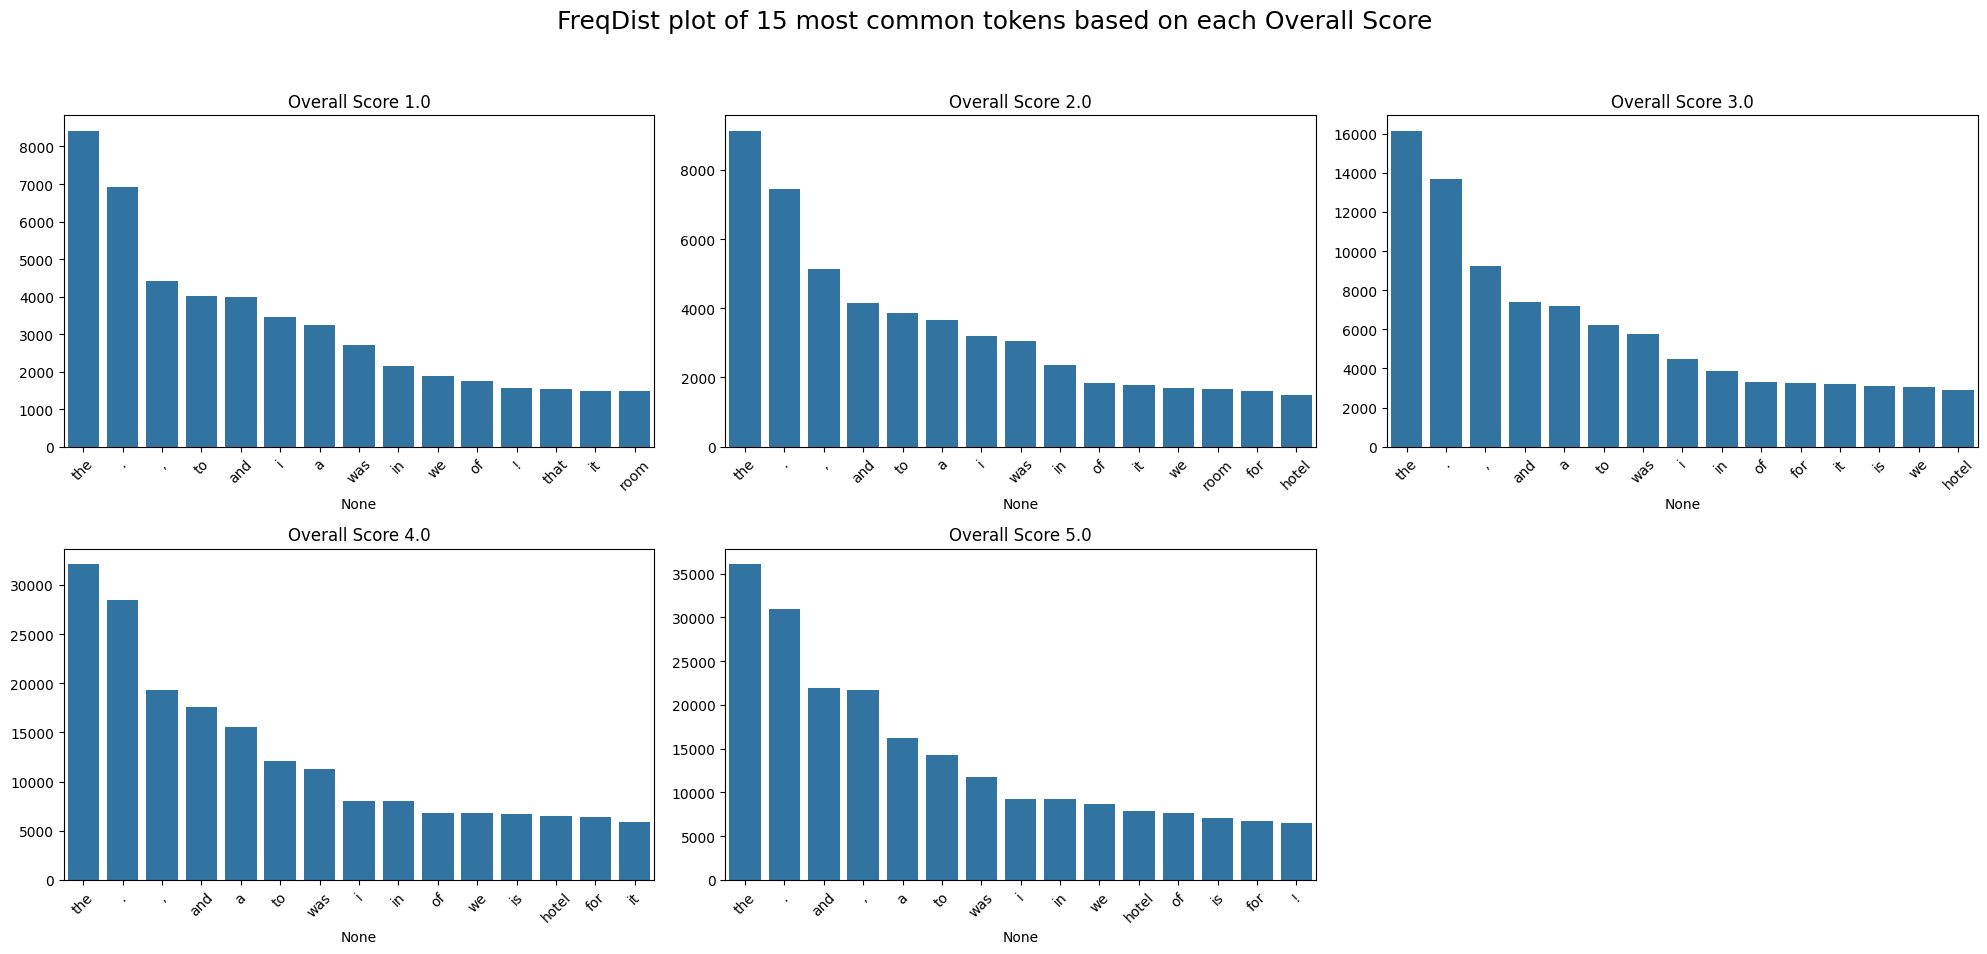

In [5]:
def get_word_frequencies(sentiment, df, top_n=15):
    # Filter text based on sentiment and tokenize
    filtered_text = df[df['overall'] == sentiment]['context']
    tokens = [word.lower() for text in filtered_text for word in word_tokenize(text)]
    
    # Calculate frequency distribution and return the top_n
    fdist = FreqDist(tokens).most_common(top_n)
    return pd.Series(dict(fdist))

def plot_Token_byOverallScore(df, top_n=15):
    unique_scores = sorted(set(df['overall']))
    n_scores = len(unique_scores)
    
    # Determine the layout dynamically
    col_set = 3
    row_set = np.ceil(n_scores / col_set).astype(int)
    
    fig, axs = plt.subplots(row_set, col_set, figsize=(20, 10))
    plt.suptitle(f"FreqDist plot of {top_n} most common tokens based on each Overall Score", fontsize=18)
    
    # Flatten the axes array for easy indexing and hide unused subplots
    axs = axs.flatten()
    for ax in axs[n_scores:]:
        ax.set_visible(False)
    
    # Plot frequency distributions
    for idx, score in enumerate(unique_scores):
        overall_frequencies = get_word_frequencies(score, df, top_n)
        sns.barplot(x=overall_frequencies.index, y=overall_frequencies.values, ax=axs[idx])
        axs[idx].set_title(f'Overall Score {score}')
        axs[idx].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the subtitle
    plt.show()

# Assuming df_dev is your DataFrame
plot_Token_byOverallScore(df_dev)

Analysis:
- The text contains punctuation and special characters that contribute no semantic value and should be eliminated.
- The occurrence of certain words displays a consistent pattern across all overall scores, indicating that the model does not exhibit a linear relationship in its associations.

### 3. Preprocessing

#### Due to the EDA processing, we will split the section into main processes

Step 1: The initial stage involves comprehensive preprocessing of the text, which encompasses:
- Eliminating all characters that are not alphanumeric.
- Excluding all characters except for whitespace, encompassing punctuation marks, symbols, and additional special characters.
- Discarding hyperlinks and references within the text, as applicable.
- Tokenizing the text subsequent to the execution of the selected cleansing procedures.
  
Step 2: The selection of the most effective text processing techniques will be based on their performance, with particular focus on: (provide the selection)
- The removal of stop words.
- The application of lemmatization.
- The conversion of all text to lowercase.

In [6]:
df_dev.head(5)

,overall,context,context_length
10000,4.0,“Nice hotel - great location” This was a nice ...,69
10001,4.0,“Perfect location and the room was generous in...,64
10002,2.0,"“Rude staff, extra charges, overall unimpressi...",279
10003,4.0,"“Great location, would stay here again” Stayed...",71
10004,3.0,“Disappointed in Chicago” I stayed at the Alle...,142


In [7]:
class Preprocess:
    def __init__(self, remove_stopwords=True, use_lower_case=True, do_lemmatize=True)->None:
        """
        Initialize the preprocessing class with options to remove stopwords, 
        convert to lower case, and lemmatize words.
        
        Params:
        method (str) - the method to use for stemming or lemmatization
        remove_stopwords (bool) - flag to indicate removal of stopwords
        use_lower_case (bool) - flag to indicate conversion to lower case
        do_lemmatize (bool) - flag to indicate whether to lemmatize words
        """
        self.remove_stopwords = remove_stopwords
        self.use_lower_case = use_lower_case
        self.do_lemmatize = do_lemmatize
        self.lmtr = WordNetLemmatizer()
        self.isFitted = False
        self.preprocessed_data = None  # Attribute to store preprocessed data
        
    def preprocess(self, message:str)->str:
        """
        Preprocess the message according to the options specified during initialization.
        """

        # Global: Remove links and mentions from the messages 
        message = re.sub(r'http[s]?://\S+', '', message)
        message = re.sub(r"@\w+", "", message)
        message = re.sub(r"\d", "", message)
        
        # Global: Remove characters that are not alphanumeric or whitespace
        message = ''.join(char for char in message if char.isalnum() or char.isspace())
        
        # Optional: convert message to lower case 
        if self.use_lower_case:
            message = message.lower()

        # Global: Tokenize the message
        words = message.split()
        
        # Optional: remove stopwords
        if self.remove_stopwords:
            words = [word for word in words if word not in list(stopwords.words('english'))]
        
        # Optional: lemmatize the words
        if self.do_lemmatize:
            words = [self.lmtr.lemmatize(word) for word in words]

        # Return the preprocessed message 
        return ' '.join(words)
    
    def fit(self, X:pd.Series)->None:
        """
        Fits the tf-idf vectorizer and label encoders according to the training data.
        """
        # Preprocess the messages first
        X = X.apply(self.preprocess)
        self.preprocessed_data = X  # Store the preprocessed data
        # Initialize the tfidf vectorizer
        self.vectorizer = TfidfVectorizer()
        # Fit the vectorizer
        self.vectorizer.fit(X)
        self.isFitted = True
        
    def transform(self, X:pd.Series)->tuple:
        """
        Transforms the given messages and labels to be suitable for machine learning models.
        """
        if not self.isFitted:
            raise NotImplementedError('The preprocess instance is not fitted yet. Please call fit() before transform().')
        
        # Preprocess the messages and vectorize
        X_transformed = self.vectorizer.transform(X.apply(self.preprocess))
        return X_transformed
    
    def fit_transform(self, X:pd.Series)->tuple:
        """
        Fits and transforms the data to be suitable for machine learning models.
        """
        self.fit(X)
        return self.transform(X)
    
    
    def get_vectorizer(self):
        return self.vectorizer

# Initialize the Preprocess class with your chosen settings
preprocessor = Preprocess(remove_stopwords=True, use_lower_case=True, do_lemmatize=True)

# Apply the fit_transform method on the 'context' column
X_transformed = preprocessor.fit_transform(df_dev['context'])

# show the processing data and transform data
preprocessor.preprocessed_data

10000    nice hotel great location nice hotel price got...
10001    perfect location room generous size stayed hot...
10002    rude staff extra charge overall unimpressive t...
10003    great location would stay stayed night room la...
10004    disappointed chicago stayed allerton hotel nig...
                               ...                        
19995    excellent hotel one best hotel stayed night gr...
19996    th stay love location convenient downtown faci...
19997    amazing booked day left prepaid internet speci...
19998    hotwire find nice accommodation landed sunday ...
19999    good location husband oct beautiful time go gr...
Name: context, Length: 10000, dtype: object

### 4. Selecting supervised method for sentiment classification

#### 4.1 Consider the following Machine Learning methods: Multinomial Naïve Bayes (MNB), Random Forest (RF), Linear Regression, SVM, k-NN, Multilayer Perceptron (MLP). Select one of these methods that you consider the most suitable for further experiments. Select evaluation metric

In [8]:
# Input Parameter
input_X = X_transformed.copy()
input_y = df_dev['overall']

Models = {
    'Naive Bayes': MultinomialNB(),
    'SVM Linear': SVC(kernel="linear", C=1),
    'SVM Radial': SVC(kernel="rbf", C=1),
    'Random Forest': RandomForestClassifier(),
    # 'Linear Reg': LinearRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP': MLPClassifier(max_iter=1000)
}

# Initialize lists to store model names and their performance metrics
model_names = []
accuracies = []
f1_scores = []

for name, model in Models.items():
    model.fit(X_transformed, input_y)
    y_pred = model.predict(X_transformed)
    
    acc = accuracy_score(input_y, y_pred)
    f1score = f1_score(input_y, y_pred, average = 'weighted')
    
    model_names.append(name)
    accuracies.append(acc)
    f1_scores.append(f1score)
    
    print(f"{name}: ")
    print(classification_report(input_y, y_pred))

# Create a DataFrame to summarize the performances
performance_summary = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

# Display the summary table
print(performance_summary)

Naive Bayes: 
              precision    recall  f1-score   support

         1.0       0.80      0.01      0.01       672
         2.0       1.00      0.00      0.00       684
         3.0       0.50      0.00      0.00      1353
         4.0       0.48      0.50      0.49      3237
         5.0       0.60      0.98      0.75      4054

    accuracy                           0.56     10000
   macro avg       0.68      0.30      0.25     10000
weighted avg       0.59      0.56      0.46     10000

SVM Linear: 
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       672
         2.0       0.95      0.83      0.89       684
         3.0       0.89      0.79      0.83      1353
         4.0       0.82      0.83      0.82      3237
         5.0       0.87      0.91      0.89      4054

    accuracy                           0.87     10000
   macro avg       0.90      0.86      0.88     10000
weighted avg       0.87      0.87      0.87     10

In this assignment, the primary evaluation metrics utilized include accuracy and the F1-score. Accuracy provides an immediate overview of the model's overall effectiveness, whereas the F1-score offers a more detailed analysis by addressing the challenges of class imbalance through a nuanced assessment of the precision-recall dynamic.

Regarding the choice of models for this task, sophisticated algorithms such as Support Vector Machines (SVM) with a radial basis function, Random Forest, and Multilayer Perceptron demonstrate superior ability to discern the complexities inherent in the data, as evidenced by their remarkable F1-scores of 0.97, 1.00, and 1.00, respectively. Conversely, simpler models such as Naive Bayes, linear SVM, and K-Nearest Neighbors (KNN) struggle to decode the intricate relationships among words, resulting in lower performance metrics. Consequently, the top-performing models will undergo further evaluation with various text processing techniques to ascertain the optimal approach.

#### 4.2 Use development datasets and 10-fold cross-validation to select text processing that yields the best results, considering the following:
- stop-word removal,
- lemmatisation
- lowercasing
- baseline as the comparison (zero-text processing)

In [9]:
# comparison between each text preprocessing
# Define preprocessing strategies
preprocessors = {
    'all': Preprocess(remove_stopwords=True, use_lower_case=True, do_lemmatize=True),
    'stop': Preprocess(remove_stopwords=True, use_lower_case=False, do_lemmatize=False),
    'lower': Preprocess(remove_stopwords=False, use_lower_case=True, do_lemmatize=False),
    'lemma': Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=True),
    'not_use': Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=False)
}

# Initialize lists to store model names and their performance metrics
preprocessors_data = []

# Initialize a dictionary to hold the performance metrics
performance_metrics = {'Preprocessor': [], 'Average Accuracy': [], 'Average F1 Score': []}
k = 10
kf = KFold(n_splits=k, random_state=1311, shuffle=True)

# Train and evaluate a model for each preprocessing strategy
for name, preprocessor in preprocessors.items():
    # Apply the fit_transform method on the 'context' column
    x_preprocessed = preprocessor.fit_transform(df_dev['context'].head(10000))
    y_preprocessed= df_dev['overall'].head(10000)

    # show the processing data and transform data
    preprocessors_data.append(preprocessor.preprocessed_data)
    
    acc_score = []
    f1_c_score = []
    
    # Perform the cross-validation
    for train_index, test_index in kf.split(x_preprocessed):
        # Use array indexing for sparse matrices
        X_train_kf, X_test_kf = x_preprocessed[train_index], x_preprocessed[test_index]
        y_train_kf, y_test_kf = y_preprocessed.iloc[train_index], y_preprocessed.iloc[test_index]

        # Train a SVM Radial on the transformed training data
        svm_rl = SVC(kernel="rbf", C=1)
        svm_rl.fit(X_train_kf, y_train_kf)
        
        # Predict on the transformed test data
        y_pred = svm_rl.predict(X_test_kf)
        
        # Make predictions and calculate accuracy and F1 score
        y_pred = svm_rl.predict(X_test_kf)
        acc_score.append(accuracy_score(y_test_kf, y_pred))
        f1_c_score.append(f1_score(y_test_kf, y_pred, average = 'weighted'))
    
    # Calculate and store the average performance metrics
    performance_metrics['Preprocessor'].append(name)
    performance_metrics['Average Accuracy'].append(np.mean(acc_score))
    performance_metrics['Average F1 Score'].append(np.mean(f1_c_score))
    
    # Print results with formatting
    print(f"SVM RBF with preprocessing {name}:")
    print(f'accuracy of each fold - {[format(score, ".3f") for score in acc_score]}')
    print(f'Avg accuracy : {format(np.mean(acc_score), ".3f")}')
    print(f'f1 score of each fold - {[format(score, ".3f") for score in f1_c_score]}')
    print(f'Avg f1 score : {format(np.mean(f1_c_score), ".3f")}')
    print("---------------------------------")
    
    
# Create a DataFrame to summarize the performances
performance_summary_pre = pd.DataFrame(performance_metrics)

# Display the summary table
print(performance_summary_pre)

SVM RBF with preprocessing all:
accuracy of each fold - ['0.595', '0.598', '0.616', '0.626', '0.621', '0.591', '0.647', '0.584', '0.614', '0.622']
Avg accuracy : 0.611
f1 score of each fold - ['0.578', '0.578', '0.601', '0.611', '0.602', '0.574', '0.629', '0.562', '0.601', '0.602']
Avg f1 score : 0.594
---------------------------------
SVM RBF with preprocessing stop:
accuracy of each fold - ['0.595', '0.600', '0.616', '0.617', '0.616', '0.586', '0.647', '0.583', '0.618', '0.620']
Avg accuracy : 0.610
f1 score of each fold - ['0.578', '0.583', '0.600', '0.601', '0.597', '0.568', '0.625', '0.561', '0.607', '0.600']
Avg f1 score : 0.592
---------------------------------
SVM RBF with preprocessing lower:
accuracy of each fold - ['0.595', '0.610', '0.622', '0.621', '0.624', '0.601', '0.657', '0.592', '0.652', '0.613']
Avg accuracy : 0.619
f1 score of each fold - ['0.580', '0.595', '0.609', '0.608', '0.603', '0.586', '0.639', '0.576', '0.641', '0.595']
Avg f1 score : 0.603
-----------------

In [10]:
# comparison between each text preprocessing
# Define preprocessing strategies
preprocessors = {
    # 'all': Preprocess(remove_stopwords=True, use_lower_case=True, do_lemmatize=True),
    'stop': Preprocess(remove_stopwords=True, use_lower_case=False, do_lemmatize=False),
    'lower': Preprocess(remove_stopwords=False, use_lower_case=True, do_lemmatize=False),
    'lemma': Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=True),
    'not_use': Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=False)
}

# Initialize a dictionary to hold the performance metrics
performance_metrics = {'Preprocessor': [], 'Average Accuracy': [], 'Average F1 Score': []}
k = 10
kf = KFold(n_splits=k, random_state=1311, shuffle=True)

# Train and evaluate a model for each preprocessing strategy
for name, preprocessor in preprocessors.items():
    # Apply the fit_transform method on the 'context' column
    x_preprocessed = preprocessor.fit_transform(df_dev['context'].head(10000))
    y_preprocessed= df_dev['overall'].head(10000)

    # show the processing data and transform data
    preprocessors_data.append(preprocessor.preprocessed_data)
    
    acc_score = []
    f1_c_score = []
    
    # Perform the cross-validation
    for train_index, test_index in kf.split(x_preprocessed):
        # Use array indexing for sparse matrices
        X_train_kf, X_test_kf = x_preprocessed[train_index], x_preprocessed[test_index]
        y_train_kf, y_test_kf = y_preprocessed.iloc[train_index], y_preprocessed.iloc[test_index]

        # Train a Random Forest on the transformed training data
        rf = RandomForestClassifier(random_state=1311)
        rf.fit(X_train_kf, y_train_kf)
        
        # Predict on the transformed test data
        y_pred = rf.predict(X_test_kf)
        
        # Make predictions and calculate accuracy and F1 score
        y_pred = rf.predict(X_test_kf)
        acc_score.append(accuracy_score(y_test_kf, y_pred))
        f1_c_score.append(f1_score(y_test_kf, y_pred, average='weighted'))
    
    # Calculate and store the average performance metrics
    performance_metrics['Preprocessor'].append(name)
    performance_metrics['Average Accuracy'].append(np.mean(acc_score))
    performance_metrics['Average F1 Score'].append(np.mean(f1_c_score))
    
    # Print results with formatting
    print(f"Random Forest with preprocessing {name}:")
    print(f'accuracy of each fold - {[format(score, ".3f") for score in acc_score]}')
    print(f'Avg accuracy : {format(np.mean(acc_score), ".3f")}')
    print(f'f1 score of each fold - {[format(score, ".3f") for score in f1_c_score]}')
    print(f'Avg f1 score : {format(np.mean(f1_c_score), ".3f")}')
    print("---------------------------------")
    
    
# Create a DataFrame to summarize the performances
performance_summary_pre = pd.DataFrame(performance_metrics)

# Display the summary table
print(performance_summary_pre)

Random Forest with preprocessing stop:
accuracy of each fold - ['0.499', '0.527', '0.502', '0.526', '0.549', '0.516', '0.567', '0.488', '0.542', '0.517']
Avg accuracy : 0.523
f1 score of each fold - ['0.435', '0.470', '0.433', '0.469', '0.491', '0.457', '0.512', '0.423', '0.480', '0.448']
Avg f1 score : 0.462
---------------------------------
Random Forest with preprocessing lower:
accuracy of each fold - ['0.484', '0.523', '0.490', '0.508', '0.535', '0.520', '0.541', '0.500', '0.507', '0.520']
Avg accuracy : 0.513
f1 score of each fold - ['0.411', '0.461', '0.419', '0.441', '0.470', '0.451', '0.479', '0.437', '0.439', '0.448']
Avg f1 score : 0.446
---------------------------------
Random Forest with preprocessing lemma:
accuracy of each fold - ['0.487', '0.504', '0.512', '0.502', '0.534', '0.526', '0.550', '0.501', '0.511', '0.529']
Avg accuracy : 0.516
f1 score of each fold - ['0.417', '0.436', '0.445', '0.430', '0.469', '0.458', '0.489', '0.428', '0.444', '0.461']
Avg f1 score : 0.4

In [11]:
# comparison between each text preprocessing
# Define preprocessing strategies
preprocessors = {
    # 'all': Preprocess(remove_stopwords=True, use_lower_case=True, do_lemmatize=True),
    'stop': Preprocess(remove_stopwords=True, use_lower_case=False, do_lemmatize=False),
    'lower': Preprocess(remove_stopwords=False, use_lower_case=True, do_lemmatize=False),
    'lemma': Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=True),
    'not_use': Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=False)
}

# Initialize a dictionary to hold the performance metrics
performance_metrics = {'Preprocessor': [], 'Average Accuracy': [], 'Average F1 Score': []}
k = 10
kf = KFold(n_splits=k, random_state=1311, shuffle=True)

# Train and evaluate a model for each preprocessing strategy
for name, preprocessor in preprocessors.items():
    # Apply the fit_transform method on the 'context' column
    x_preprocessed = preprocessor.fit_transform(df_dev['context'].head(10000))
    y_preprocessed= df_dev['overall'].head(10000)

    # show the processing data and transform data
    preprocessors_data.append(preprocessor.preprocessed_data)
    
    acc_score = []
    f1_c_score = []
    
    # Perform the cross-validation
    for train_index, test_index in kf.split(x_preprocessed):
        # Use array indexing for sparse matrices
        X_train_kf, X_test_kf = x_preprocessed[train_index], x_preprocessed[test_index]
        y_train_kf, y_test_kf = y_preprocessed.iloc[train_index], y_preprocessed.iloc[test_index]

        # Train a Random Forest on the transformed training data
        mlp = MLPClassifier(max_iter=1000)
        mlp.fit(X_train_kf, y_train_kf)
        
        # Predict on the transformed test data
        y_pred = mlp.predict(X_test_kf)
        
        # Make predictions and calculate accuracy and F1 score
        y_pred = mlp.predict(X_test_kf)
        acc_score.append(accuracy_score(y_test_kf, y_pred))
        f1_c_score.append(f1_score(y_test_kf, y_pred, average='weighted'))
    
    # Calculate and store the average performance metrics
    performance_metrics['Preprocessor'].append(name)
    performance_metrics['Average Accuracy'].append(np.mean(acc_score))
    performance_metrics['Average F1 Score'].append(np.mean(f1_c_score))
    
    # Print results with formatting
    print(f"MLP with preprocessing {name}:")
    print(f'accuracy of each fold - {[format(score, ".3f") for score in acc_score]}')
    print(f'Avg accuracy : {format(np.mean(acc_score), ".3f")}')
    print(f'f1 score of each fold - {[format(score, ".3f") for score in f1_c_score]}')
    print(f'Avg f1 score : {format(np.mean(f1_c_score), ".3f")}')
    print("---------------------------------")
    
    
# Create a DataFrame to summarize the performances
performance_summary_pre = pd.DataFrame(performance_metrics)

# Display the summary table
print(performance_summary_pre)

MLP with preprocessing stop:
accuracy of each fold - ['0.550', '0.552', '0.541', '0.584', '0.559', '0.553', '0.563', '0.559', '0.568', '0.555']
Avg accuracy : 0.558
f1 score of each fold - ['0.544', '0.547', '0.536', '0.577', '0.551', '0.549', '0.558', '0.551', '0.567', '0.547']
Avg f1 score : 0.553
---------------------------------
MLP with preprocessing lower:
accuracy of each fold - ['0.559', '0.554', '0.535', '0.585', '0.556', '0.555', '0.566', '0.557', '0.575', '0.560']
Avg accuracy : 0.560
f1 score of each fold - ['0.553', '0.549', '0.531', '0.579', '0.549', '0.551', '0.559', '0.550', '0.573', '0.554']
Avg f1 score : 0.555
---------------------------------
MLP with preprocessing lemma:
accuracy of each fold - ['0.541', '0.561', '0.524', '0.582', '0.562', '0.554', '0.581', '0.541', '0.579', '0.557']
Avg accuracy : 0.558
f1 score of each fold - ['0.537', '0.556', '0.519', '0.573', '0.558', '0.551', '0.576', '0.535', '0.575', '0.551']
Avg f1 score : 0.553
---------------------------

In the process of selecting an appropriate model, the Support Vector Machine (SVM) with a radial basis function kernel, coupled with minimal text preprocessing as lower function, emerged as the superior option in comparison to other models. This model demonstrated an ability to effectively discern distinct patterns, achieving an accuracy of 0.619 and an F1-score of approximately 0.603.

### 5. Sentiment classification using VADER lexicon and method

In [12]:
def apply_vadar(df):
    # setting analyser 
    analyser = SentimentIntensityAnalyzer()
    df['pos'] = [ analyser.polarity_scores(i)['pos'] for i in df['context']]
    df['neg'] = [ analyser.polarity_scores(i)['neg'] for i in df['context']]
    df['neu'] = [ analyser.polarity_scores(i)['neu'] for i in df['context']]
    df['compound'] = [ analyser.polarity_scores(i)['compound'] for i in df['context']]
    # Determine sentiment_pos based on pos > neg
    df['sentiment_pos'] = (df['pos'] > df['neg']).astype(int)
    return df

df_dev_vadar = apply_vadar(df_dev)
df_dev_vadar

,overall,context,context_length,pos,neg,neu,compound,sentiment_pos
10000,4.0,“Nice hotel - great location” This was a nice ...,69,0.305,0.000,0.695,0.9725,1
10001,4.0,“Perfect location and the room was generous in...,64,0.283,0.037,0.680,0.9610,1
10002,2.0,"“Rude staff, extra charges, overall unimpressi...",279,0.192,0.106,0.703,0.9890,1
10003,4.0,"“Great location, would stay here again” Stayed...",71,0.109,0.093,0.798,0.0431,1
10004,3.0,“Disappointed in Chicago” I stayed at the Alle...,142,0.040,0.049,0.912,-0.3197,0
...,...,...,...,...,...,...,...,...
19995,5.0,“Excellent Hotel” One of the best hotels I hav...,65,0.262,0.047,0.691,0.9217,1
19996,4.0,“My 4th stay and I love it.” The location is c...,25,0.537,0.000,0.463,0.9678,1
19997,5.0,“Amazing!” We booked (the day before we left) ...,76,0.168,0.000,0.832,0.9133,1
19998,4.0,“Hotwire Find!” Very nice accommodation that I...,52,0.260,0.000,0.740,0.9442,1


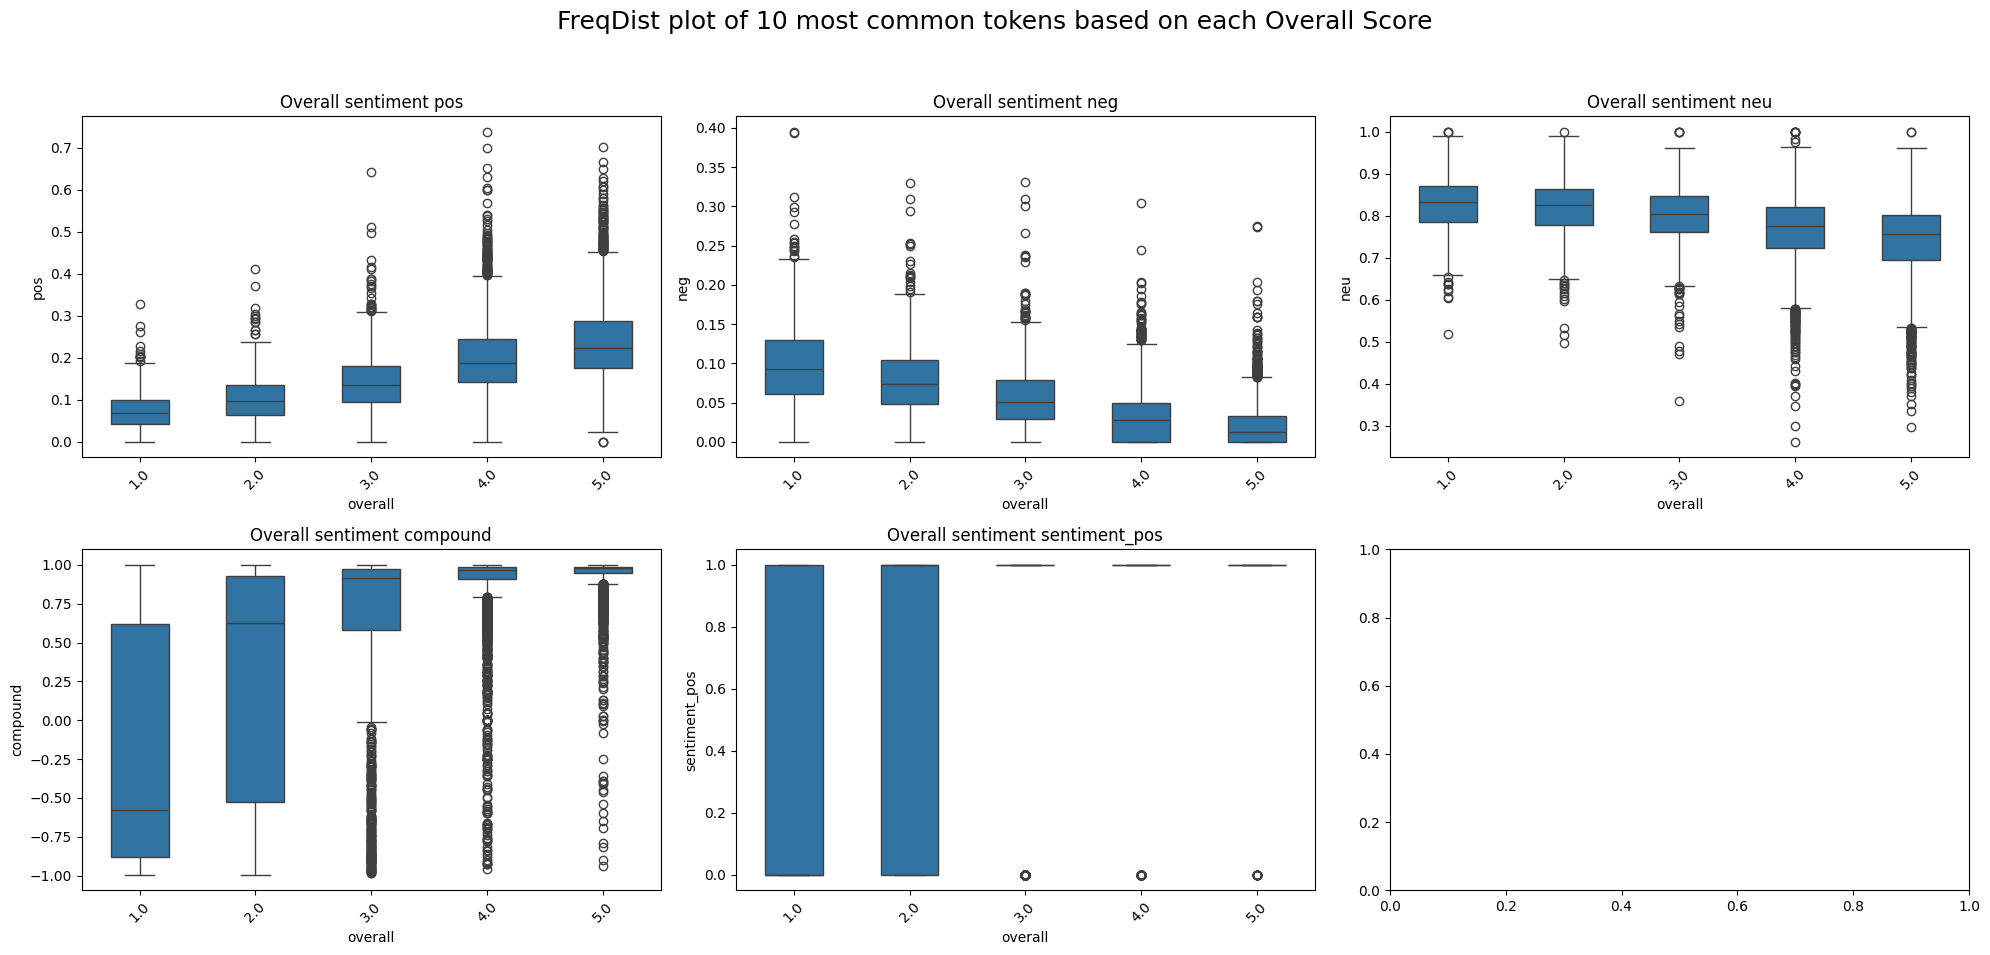

In [13]:
def plot_vadar_results(df):
    # set subplot
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    plt.suptitle(f"FreqDist plot of 10 most common tokens based on each Overall Score", fontsize=18)
    
    # Flatten the axes array for easy indexing and hide unused subplots
    axs = axs.flatten()
    for idx, sentiment in enumerate(df_dev_vadar.columns[3:]):
        # overall_frequencies = get_word_frequencies(sentiment, df, top_n)
        sns.boxplot(data=df, x="overall", y= sentiment, width=.5, ax=axs[idx])
        # sns.barplot(x=overall_frequencies.index, y=overall_frequencies.values, ax=axs[idx])
        axs[idx].set_title(f'Overall sentiment {sentiment}')
        axs[idx].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the subtitle
    plt.show()
    
plot_vadar_results(df_dev_vadar)

#### Analysis:
Based on the analysis illustrated by the plot correlating overall ratings with the outcomes derived from VADER sentiment analysis, the data reveals notable relationships. A modest correlation is observed between the overall scores and the positive, neutral, and negative sentiment scores. Conversely, the correlation between overall scores and the compound sentiment scores exhibits a more complex trend, indicating a pattern that is challenging to capture.

### 6. Combining VADER with the best classifier

In [14]:
import scipy

def merge_vadar(df, tfidf_vectorizer=None , features = ['context_length','pos','neg','neu','compound','sentiment_pos'], is_train = False):
    
    # Check if tfidf_vectorizer is provided, otherwise fit_transform on df['context']
    if tfidf_vectorizer is None:
        selected_preprocess = Preprocess(remove_stopwords=False, use_lower_case=False, do_lemmatize=True)
        X_transformed_vdr = selected_preprocess.fit_transform(df['context'])
        tfidf_vectorizer = selected_preprocess.vectorizer  # Assuming Preprocess class has a 'vectorizer' attribute
    else:
        X_transformed_vdr = tfidf_vectorizer.transform(df['context'])
    
    # Convert the TF-IDF array to a pandas DataFrame - for merging
    tfidf_df = pd.DataFrame(X_transformed_vdr.toarray(), columns=[f'tfidf_{i}' for i in range(X_transformed_vdr.shape[1])])
    
    # Finally merging all features with above TF-IDF. 
    tfidf_df = pd.concat([tfidf_df, df[features].reset_index(drop=True)], axis=1)
    
    # Convert a pandas DataFrame to the TF-IDF array - for increasing training speed
    tfidf_df = scipy.sparse.csr_matrix(tfidf_df.values)
    
    return tfidf_df, tfidf_vectorizer

def train_fit(model, x_train, y_train, x_test = None, y_test = None, validate = True, n_kfold = 10):
    # set number of fold for cross validation
    
    if validate:
        kf = KFold(n_splits=n_kfold, random_state=1311, shuffle=True)
        
        # collecting metrics
        acc_score = []
        f1_c_score = []
        
        # Perform the cross-validation
        for train_index, test_index in kf.split(x_train):
            # Use array indexing for sparse matrices
            X_train_kf, X_test_kf = x_train[train_index], x_train[test_index]
            y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            # Train a SVM Radial on the transformed training data
            # svm_rl = SVC(kernel="rbf", C=1)
            model.fit(X_train_kf, y_train_kf)
            
            # Predict on the transformed test data
            y_pred = model.predict(X_test_kf)
            
            # Make predictions and calculate accuracy and F1 score
            acc_score.append(accuracy_score(y_test_kf, y_pred))
            f1_c_score.append(f1_score(y_test_kf, y_pred, average='weighted'))
            
        # Print results with formatting
        avg_acc_score = np.mean(acc_score)
        avg_f1_score = np.mean(f1_c_score)
        
        # print(f"SVM RBF with preprocessing {name}:")
        print(f'accuracy of each fold - {[format(score, ".3f") for score in acc_score]}')
        print(f'Avg accuracy : {format(avg_acc_score, ".3f")}')
        print(f'f1 score of each fold - {[format(score, ".3f") for score in f1_c_score]}')
        print(f'Avg f1 score : {format(avg_f1_score, ".3f")}')
        print("---------------------------------")
        return y_pred, avg_acc_score, avg_f1_score
    
    else:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        acc_score = accuracy_score(y_test, y_pred)
        f1_c_score = f1_score(y_test, y_pred, average='weighted')

        print(f'Avg accuracy : {format(acc_score, ".3f")}')
        print(f'Avg f1 score : {format(f1_c_score, ".3f")}')
        
        return y_pred, acc_score, f1_c_score

svm_rl = SVC(kernel="rbf", C=1)
x_preprocessed, _ = merge_vadar(df_dev_vadar, features =['pos','neg','neu'])
y_preprocessed = df_dev_vadar['overall']
train_fit(model = svm_rl,
          x_train = x_preprocessed, 
          y_train = y_preprocessed, 
          x_test = None, 
          y_test = None, 
          validate = True, 
          n_kfold = 10
          )

accuracy of each fold - ['0.612', '0.615', '0.623', '0.641', '0.639', '0.600', '0.656', '0.602', '0.631', '0.617']
Avg accuracy : 0.624
f1 score of each fold - ['0.600', '0.604', '0.611', '0.632', '0.623', '0.589', '0.643', '0.589', '0.624', '0.602']
Avg f1 score : 0.612
---------------------------------


(array([4., 5., 4., 5., 5., 4., 5., 5., 2., 4., 5., 5., 5., 5., 4., 4., 1.,
        5., 5., 5., 5., 4., 4., 3., 5., 4., 4., 5., 4., 5., 5., 5., 4., 4.,
        3., 4., 5., 4., 1., 4., 2., 5., 4., 4., 3., 1., 4., 4., 3., 5., 5.,
        5., 5., 4., 3., 5., 5., 5., 4., 5., 5., 5., 1., 4., 5., 1., 5., 4.,
        3., 4., 4., 5., 5., 5., 5., 5., 4., 4., 5., 3., 5., 5., 5., 5., 4.,
        2., 5., 4., 5., 4., 4., 4., 4., 5., 5., 3., 5., 4., 4., 4., 3., 4.,
        2., 3., 4., 5., 3., 5., 5., 4., 5., 5., 4., 4., 5., 5., 4., 2., 3.,
        4., 5., 4., 3., 4., 5., 5., 5., 4., 5., 5., 4., 5., 5., 5., 4., 5.,
        5., 5., 5., 4., 5., 4., 1., 1., 5., 5., 5., 5., 5., 4., 3., 3., 4.,
        5., 5., 3., 3., 5., 4., 5., 5., 1., 4., 5., 5., 3., 4., 4., 4., 4.,
        3., 5., 5., 5., 2., 4., 5., 5., 5., 5., 5., 4., 4., 5., 4., 3., 4.,
        5., 5., 4., 4., 1., 2., 4., 2., 4., 3., 5., 5., 1., 4., 4., 5., 3.,
        5., 1., 5., 5., 5., 5., 3., 5., 5., 4., 4., 2., 2., 5., 4., 5., 3.,
        3., 

In [15]:
## run for all parameter
svm_rl = SVC(kernel="rbf", C=1)
x_preprocessed, _ = merge_vadar(df_dev_vadar)
y_preprocessed = df_dev_vadar['overall']
train_fit(model = svm_rl,
          x_train = x_preprocessed, 
          y_train = y_preprocessed, 
          x_test = None, 
          y_test = None, 
          validate = True, 
          n_kfold = 10
          )

accuracy of each fold - ['0.363', '0.430', '0.389', '0.412', '0.424', '0.417', '0.423', '0.384', '0.420', '0.414']
Avg accuracy : 0.408
f1 score of each fold - ['0.217', '0.291', '0.244', '0.260', '0.277', '0.278', '0.276', '0.230', '0.283', '0.264']
Avg f1 score : 0.262
---------------------------------


(array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5.,
        5., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 4., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 

#### Analysis:
Incorporating selected features from the VADER sentiment analysis—namely, positive (pos), negative (neg), and neutral (neu) indicators—into the model has been demonstrated to enhance its performance. This enhancement is evidenced by a comparative analysis of model outcomes, where the inclusion of all VADER parameters yielded a performance metric as accuracy of 0.408. In contrast, a more selective approach focusing solely on the aforementioned features resulted in a superior performance metric of 0.626. This outcome surpasses the performance of models that did not utilize any VADER-based feature engineering, underscoring the efficacy of targeted sentiment feature inclusion in improving model accuracy.

### 7. Training and testing the final method

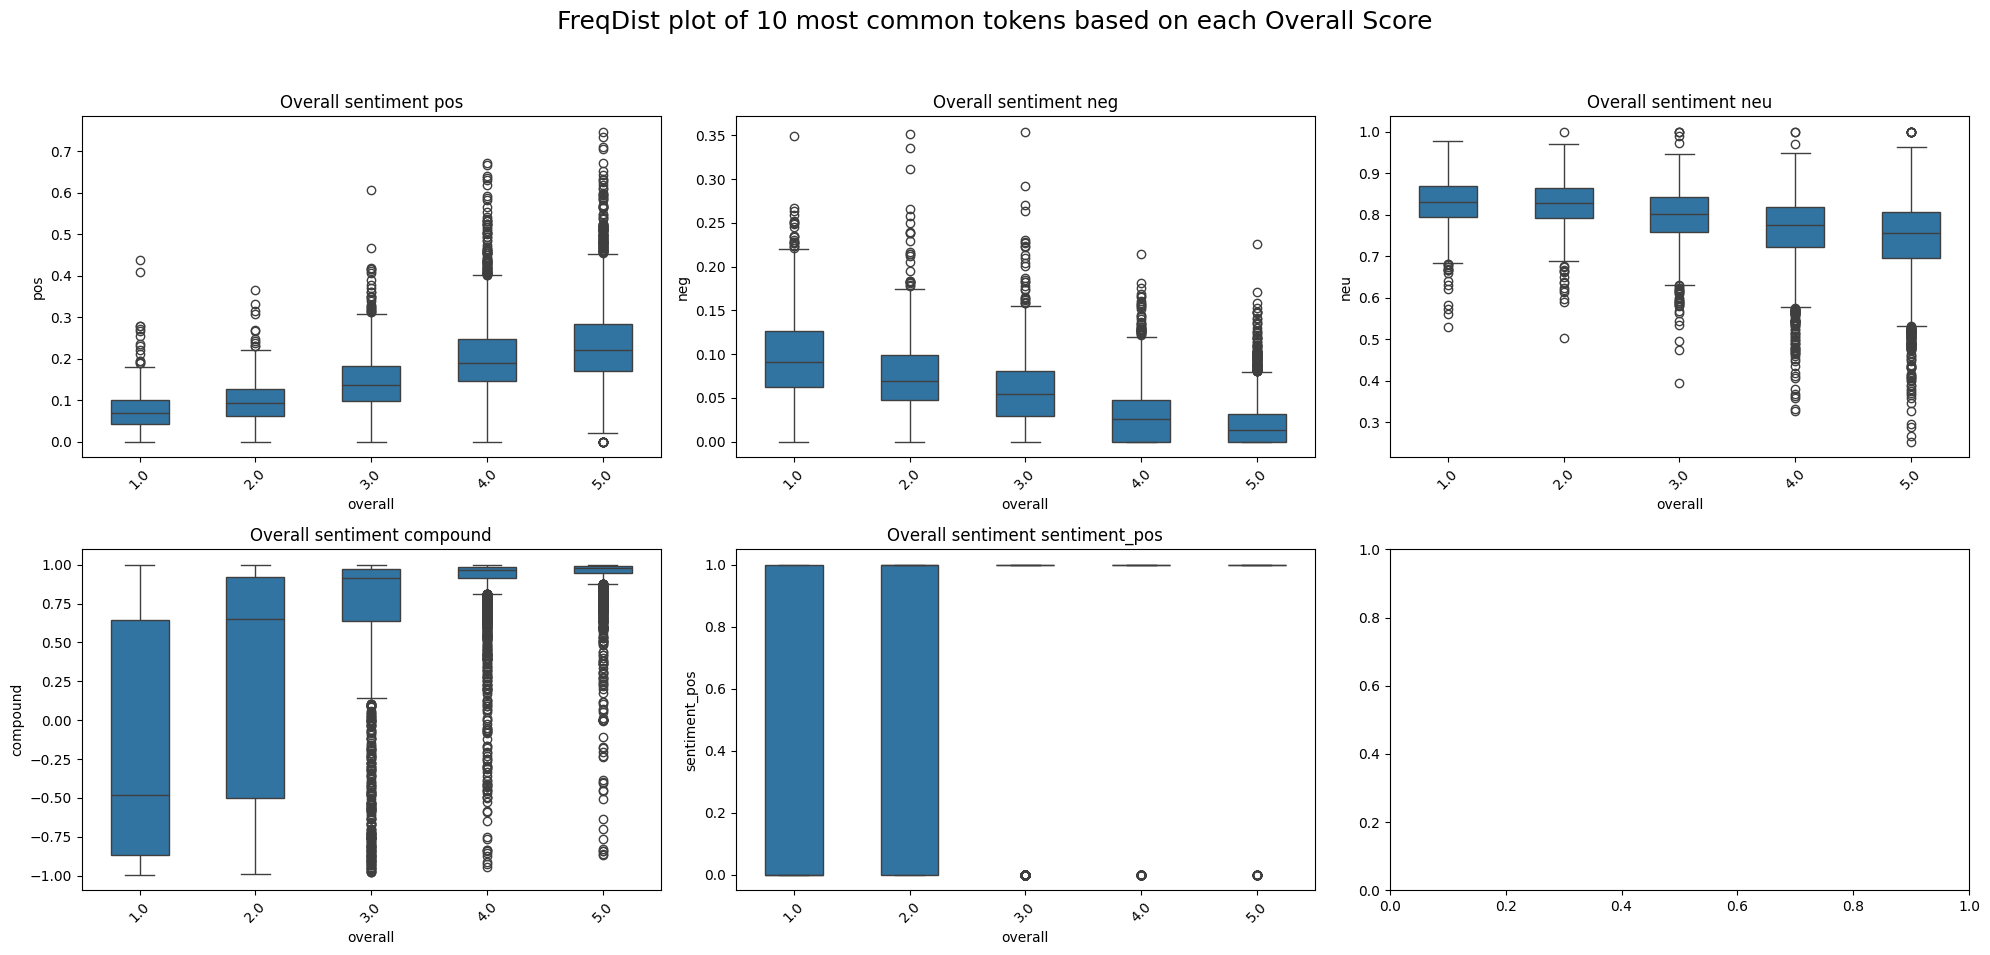

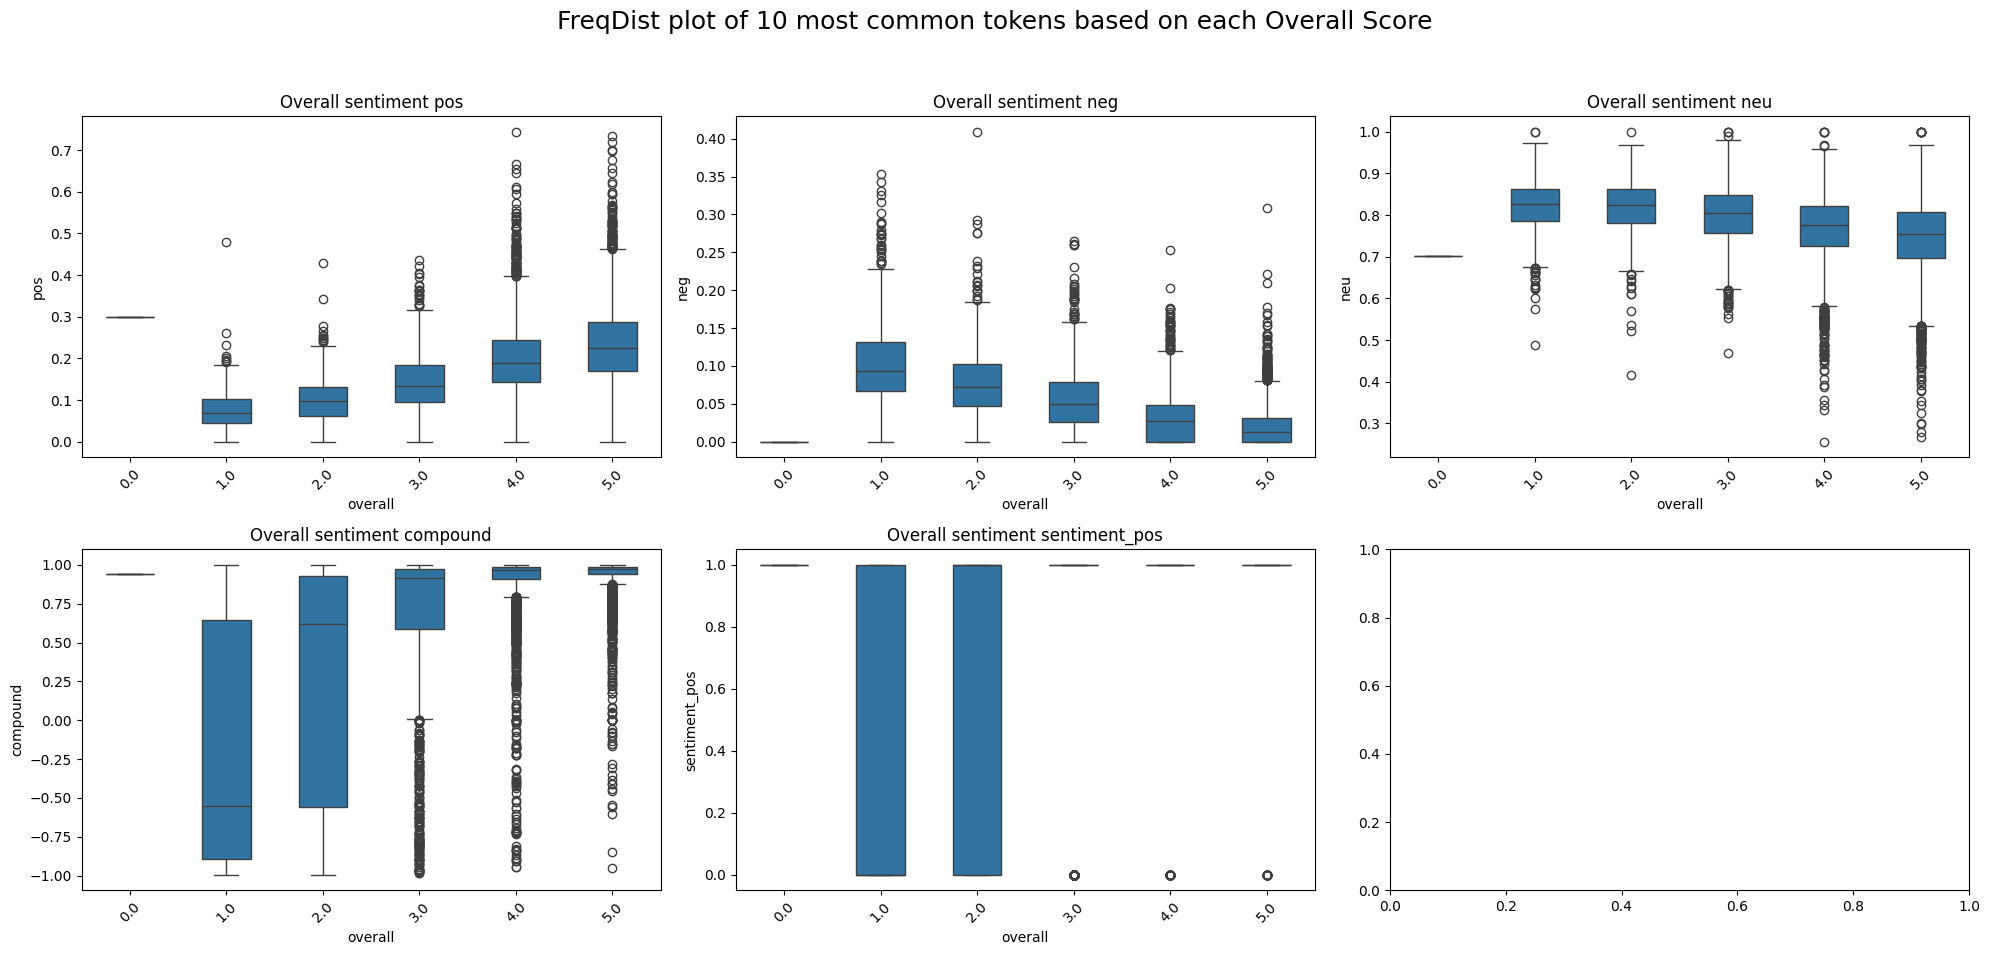

In [16]:
# compare ther results from original best model from part4 and part4 combine with vadar 
df_train_vadar = apply_vadar(df_train)
df_test_vadar = apply_vadar(df_test)

tfidf_vectorizer = None  # Initialize to None for training
x_train_pre, tfidf_vectorizer = merge_vadar(df_train_vadar, features=['pos','neg','neu'])
y_train_pre = df_train_vadar['overall']

x_test_pre, _ = merge_vadar(df_test_vadar, tfidf_vectorizer, features=['pos','neg','neu'])
y_test_pre = df_test_vadar['overall']

plot_vadar_results(df_train_vadar)
plot_vadar_results(df_test_vadar)

#### Analysis:
The performance of VADER sentiment analysis on both the training and testing datasets exhibits similar outcomes to those observed in the development dataset, indicating a discernible correlation between positive and negative sentiments and the overall score.

In [17]:
svm_rl = SVC(kernel="rbf", C=1)
train_fit(model = svm_rl,
          x_train = x_train_pre, 
          y_train = y_train_pre, 
          x_test = x_test_pre, 
          y_test = y_test_pre, 
          validate = False
          )

Avg accuracy : 0.622
Avg f1 score : 0.612


(array([4., 5., 4., ..., 3., 5., 5.]), 0.6217, 0.612145200790536)

#### Analysis:
Utilizing a methodology that integrates VADER sentiment analysis with the optimal approach previously identified, the outcomes demonstrate an improvement, with an accuracy of 0.622 and an F1-score of 0.612. This enhancement, when compared to the top-performing results identified in section 4, underscores the efficacy of incorporating VADER as a means of feature engineering. Specifically, it highlights VADER's capacity to reveal nuanced details within the sentiment data, thereby serving as a valuable additional parameter that enriches the analysis beyond the capabilities presented in section 4.

### 8. Reviews aspect prediction

This proposal aims to enhance sentiment analysis in hotel reviews by focusing on specific aspects such as cleanliness and service, employing Aspect-Based Sentiment Analysis (ABSA). ABSA addresses the limitations of traditional sentiment analysis by providing detailed insights into particular facets of hotel services.

Main Methodologies consists of
- 01: Data Preparation or Data Preprecossing: The first step involves cleaning and preparing the data for analysis. This includes lowercasing text, removing punctuation and stop words, and applying tokenization and lemmatization to standardize the text for further processing. These preprocessing steps are crucial for reducing noise and focusing on the meaningful content of the reviews which similar to traditional sentiment analysiks
- 02: Aspect Identification: Using techniques such as Named Entity Recognition (NER) and dependency parsing, identify key nouns and noun phrases that represent hotel aspects within the review texts. Additionally, machine learning models like CRF (Conditional Random Fields) or deep learning approaches such as LSTM (Long Short-Term Memory) networks can be employed to accurately detect and categorize mentioned aspects
- 03: Sentiment Determination: For each extracted aspect, perform sentiment analysis to determine the polarity (positive, negative, neutral) of the sentiment expressed towards it. Following the step in this assignment or using pre-trained LMM models, fine-tuned for the hospitality context, offer state-of-the-art performance for this task by capturing the context around each aspect.
- 04: Rating or score Prediction: Summarize the sentiment ratings for every aspect from all reviews to forecast the comprehensive score for that aspect. Regression models, considering both the occurrence and strength of sentiments related to each aspect, can facilitate this. Such an approach offers a detailed insight into guest satisfaction across various service dimensions.
- 05: Evaluation: Employ metrics such as the F1-score for aspect categorization accuracy and MAE (Mean Absolute Error) for the precision of aspect rating predictions. These metrics facilitate a comprehensive evaluation of the model's performance across different aspects of hotel services.

Therefore, this proposal recommends using an Aspect-Based Sentiment Analysis (ABSA) strategy to break down hotel reviews by specific aspects, providing in-depth observations of guest experiences. Through the incorporation of sophisticated Natural Language Processing (NLP) methods and machine learning algorithms, the suggested approach seeks to improve the accuracy of sentiment analysis within the hospitality industry. This, in turn, will allow stakeholders to make well-informed choices informed by comprehensive, aspect-specific feedback.

### 9. References

- [Section:Preprocessing] https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
- [Section:Preprocessing] https://aayushmaan1306.medium.com/basics-of-natural-language-processing-with-scikit-learn-and-nltk-3631917b6b3d
- [Section:ApplyVADAR] https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/
- [Section:Aspect-BasedSentimentAnalysis] https://medium.com/nlplanet/quick-intro-to-aspect-based-sentiment-analysis-c8888a09eda7
- [Section:Aspect-BasedSentimentAnalysis] https://arxiv.org/abs/2311.10777

